# Generating Text with an RNN

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/My Drive/MP-1/Assignment4")

In [0]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [0]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [0]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [0]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

hink my son to be as dear to me!
Sufficeth not that we are brought to Rome,
To beautify thy triumphs and return,
Captive to thee and to thy Roman yoke,
But must my sons be slaughter'd in the streets,
F


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [0]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [0]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [0]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [0]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [0]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    hidden=rnn.init_hidden(input.size(0))
    rnn.zero_grad()
    for i in range(input.size(1)):
      output,hidden= rnn(input[:,i], hidden)
      
      loss += criterion(output.reshape(input.size(0), -1), target[:,i])
    loss=loss/chunk_len
    loss.backward()
    optimizer.step()
    #print(loss)
    
    ##########       END      ##########

    return loss.data.item()


In [0]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 54s (50 1%) train loss: 2.0968, test_loss: 2.0765]
Wher'd thear stess, ly to se ourntink and shay veath, for me lime ereace in will hast thyt, wood you,  

 49s (100 2%) train loss: 1.9216, test_loss: 1.9476]
Why thou dey that a with of I dimy thee ut a dost it Maingets
Themer
the thou do this love must the mi 

 44s (150 3%) train loss: 1.8556, test_loss: 1.8875]
Whit worded had mothing in than the hage valecesnient; the waughture,
Thee,
Tell the suse my sire mang 

 38s (200 4%) train loss: 1.8270, test_loss: 1.8312]
Whis not to thou naw merridion well of too, how who rose in than than and never, goders: I heak our be 

 33s (250 5%) train loss: 1.7603, test_loss: 1.8296]
Whis one. Pard
The she the trefenty they dear to be hold much the with be not plaif and at me that hav 

 27s (300 6%) train loss: 1.7741, test_loss: 1.7968]
Wh their exen here than home by that I shorn better me to the bather shall not manies; I would holl hi 

 22s (350 7%) train loss:

In [0]:
#save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

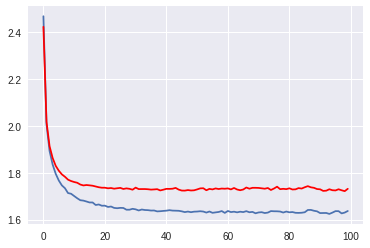

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [0]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The had heard nack to this so be she may a wreny like now and his good being
Hath it may not hear her much of such this in breath'd, brave take hearts him that in the heart.

FALOE:
Servillal, as thou cannot child the ment a better the see a lord for the gladves me not sharid Apite,
And I have at his about of before that such on the false I rageting, if unto her thee all a newssorse was dainted,
And so so
It thee they there he you that my sended one from your bed.

Second Wadems, Lord meive here the actions appear shade his chalk 'tis news, shall breachten
May from Here.

PANICE:
Have all him.

HAMLET:
If warrous the noble placemed had that I could his more there the pouble of your mind
This the deard; and here'd of Her the good Caddold mistress us this striker, yet they ten gone, be heart.

HULENGHZ:
Bear from them, before high every
My heart, a did thy country, and thou tear Lord love with the percease,
The comes, and shall I am not silst devil he for see the love same, can-sully tha

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

MODEL-GRU

In [17]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type='gru', n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 15s (50 1%) train loss: 2.0846, test_loss: 2.1109]
Whardis walle stis me and and o waster a houning;
And me as silly for the that thand his ben dreand, o 

 30s (100 2%) train loss: 1.9326, test_loss: 1.9077]
Whish the to
Apatest more all say ould somake, and indine, the scarty, to the toult will the pomen
thi 

 46s (150 3%) train loss: 1.7894, test_loss: 1.8217]
Whoughts my marts of complessed, Beased
Nest the treesand with the now trught, tor and a that hath and 

 2s (200 4%) train loss: 1.7491, test_loss: 1.7691]
Where than swerong:
What comment thee we'er were both is with your heaves.

SHELLAND:
I have score the 

 18s (250 5%) train loss: 1.7012, test_loss: 1.7278]
When the fathers and the becort me be
frow afterowad of you noths in manger down;
And stol's but hece  

 34s (300 6%) train loss: 1.6369, test_loss: 1.7036]
When May, Colet bours, praled.

HELIA:
What you, no cannet the dead have forty
meep the man prouse day 

 50s (350 7%) train loss: 

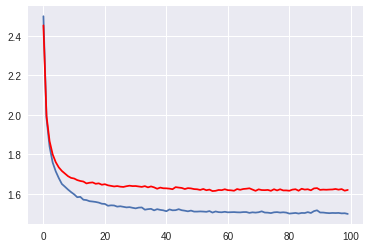

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [19]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The worth the even, the least so
that entellenudes of the speech poor from our
to me when have stand in me; the brief, all thy sweet
As expefore you no king well interchascly an
assued, day a sounds out deparfeit he is thy offers
For her profoot was not a heart here?

CLEOPATRA:
Why, I then thou deared, to keep you, as these every thous

ORSIUS:
A worthy remus' win,--
I the more, I do it of all sole been preservant
Make me to that be be personest when you say,
And seem'd.

Clown:
A manight by this main to Lord Gentlemany
To the canbs arding the man a virtuance to
The wings of sorrow of your deserlce
That in percealst creaters to this masten of his world.

CLAUDIUS:
Ay, sir Edward? nor you not thou wither'd.

First Lord:
I am the dearer shall not no speedy that know to not;
And, 'twas so father thence show them with a perfite
To hath nother with the dame that well.

CORNWALL:
Ay, when to peace, I should not be defended of the fulies
That provoke her friend to his bone.

CORNWALL:
My lor

MODEL-LSTM

In [20]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type='lstm', n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 19s (50 1%) train loss: 2.1162, test_loss: 2.1203]
Whou stit dis it on the wire, shall thou dor the pwice. antest the sport hark the on will hound and th 

 41s (100 2%) train loss: 1.9298, test_loss: 1.9298]
Whering of the proces 'this
Thouse your will thee resire ever waites, I any kno prowchines onore as me 

 1s (150 3%) train loss: 1.8427, test_loss: 1.8467]
Whore beards in themn's dears'd here bet his thee and thee lord shall wown the rave sild that not I wh 

 22s (200 4%) train loss: 1.7883, test_loss: 1.8159]
Why to can thee to make the be rest to mency if I welf
There pound a that be even thow thy girlow,
I w 

 42s (250 5%) train loss: 1.7332, test_loss: 1.7643]
What he dote Stircily,
When is not rest I would gatch me were the sto-sir, I know your choor the warrt 

 4s (300 6%) train loss: 1.6962, test_loss: 1.7375]
What I came off
And we nother rest--
That of the chap the how a make as that fear is thy pass'd me and 

 24s (350 7%) train loss: 1

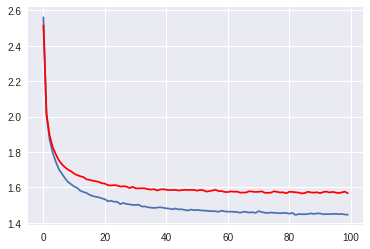

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [22]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The honour to go.

IAGO:
I mean, for worthary, friends: are you:
The lady be sound his soul canst to please.

BENEDICK:
Ay! 'Twill doth not you we make her with my haws?
That's to prithee, and thive him as doul Christian his fear,
And she's no boys are so it should ceptreed.

KING HENRY VIII:
Sirchmen?

ROSALIND:
The beagens of his heavy carrile
The quarrel pleasure sense fools, gods be words of a way rawne
To make our dead of York for the resolves.

Witthars:
Thiever of the poor upon thy pewnant
As I'll be the voice for it see this fourtery.

KING HENRY VI:
I'll be haste we did cares please
But I have to shall death maker unto a man for hernest in fear'd you
And Celt you.

TITUS ANDRONICUS:
Sire in my stands, counter does o'er the news upon the good flower tents
To hear flyoust stand in the shawe strange his, for he will.

Second Lord:
Therefore eneces too shall choes.

ACHILLES:
Go you: we should be men.

Gho what must not we are before him not a favoured,
And we had her from the sin

Changing the hyper-parameters:
such as increased hidden_size and number of layers

In [0]:
batch_size = 100
n_epochs = 5000
hidden_size = 150
n_layers = 2
learning_rate = 0.001
model_type = 'lstm'
print_every = 50
plot_every = 50


In [24]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type='lstm', n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 55s (50 1%) train loss: 3.1081, test_loss: 3.0919]
Wh$h?bNaRm yole tern aoioe e ty
e t h hrf o maow runte an ddr thf rht anw a ueel cnoe liailn ehn hu or 

 49s (100 2%) train loss: 2.5890, test_loss: 2.5833]
Whioe an thasoh cose eord nkdety mouf woec be fonl herds me thikt apges-he he larkel ike to heH
hoeet  

 45s (150 3%) train loss: 2.3362, test_loss: 2.3374]
Whit eove
An the sonu the wel morve and tere toR,
Ies bome the dos shos, call thers enF wal wheis me o 

 38s (200 4%) train loss: 2.2095, test_loss: 2.2252]
Whmale and nitteng by I fivith hit I whas ows nom wors ard of miy locome for in at pmat or, I thou hey 

 33s (250 5%) train loss: 2.1064, test_loss: 2.1338]
Whe thean doth
Made, the lomt, gteres,
He berriethye
hou worrbe thive lecistises at helinde, seall cin 

 28s (300 6%) train loss: 2.0394, test_loss: 2.0516]
Whep'dsech bear the worr pourdlate mes to to she; to the, (ore, shath I is fey me tell frince miny lil 

 21s (350 7%) train loss:

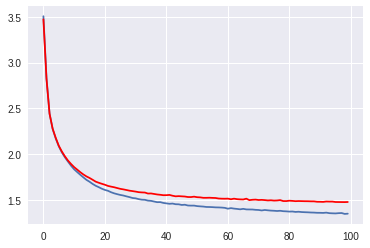

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [26]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

That been well and pretidity have the king of
ere is with sure. With this such a hung the dispose
And law the tongues she will left the land.

LORD POLONIUS:
It is in worth me to have purpose thine end
Through Milan nick with me to the fuety.
O good Cemention of the funtine?

IANGA:
It is the devil call these thunder be rather
Mark the dead from the child with her gods beat,
Though all the bear in feachery of every lands
Besides deform'd upon the white common.

HOLOFERNES:
Go be the very want in the glorious attimetion,
And not that it is no.

OELIET:
Yes, mamer wakes on a husband, now,
The gallant earth of thy pride of the Grace,
for twelve is curse of hold gold of him with the whole:
I have been away the deeds with our play
Hath the Roman boldly be amending to him.

PANDARUS:
The great particulors eateth and honestly
That would he never follows the vests
In go fear to die, that he would be terrissed
it he know as guins, when they shall see him; let ran
Neek to steel the bitter from h